In [1]:
import numpy as np
import pandas as pd

from scipy.integrate import quad
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

from tqdm import tqdm
import warnings

In [2]:
def subpool(r,f,subsize,n):
    '''
    筛选夏普比最大的子股票池
    '''
    sharpe_pool = [] # 储存所有sharpe比
    col_pool = [] # 储存所有columns

    # 随机挑选子股票池并循环该过程
    for _ in range(n):
        #np.random.seed(i) # 设计随机抽样的种子
        substock = np.random.choice(r.columns,subsize,replace=False)
        col_pool.append(substock)
    
        total = np.array(pd.concat([f,r[substock]],axis=1)) # 合成total，用以计算总体的sharpe
        subsharpe = sharpe(total,adjust=True)
        sharpe_pool.append(subsharpe)

    # 筛选sharpe比在95%处的投资组合
    sharpe_pool = np.array(sharpe_pool)
    selected_index = np.where(sharpe_pool >= np.quantile(sharpe_pool,0.95))[0]
    selected_index = selected_index[np.argmin(sharpe_pool[selected_index])]
    selected_col = col_pool[selected_index]
        
    return selected_col

In [3]:
def sharpe(r,adjust=False):
    '''
    获得一个rolling windows的beta值
    '''
    r = np.array(r) # 调整数据格式
    T = r.shape[0]
    N = r.shape[1]
    
    mu = r.mean(axis=0).reshape(-1,1)
    SIGMA = np.dot((r - mu.T).T,(r - mu.T))/(T-1)
        
    # sharpe比
    sharpe_s_all = mu.T @ np.linalg.inv(SIGMA) @ mu # 没调整的sharpe比
    if adjust:
        # 调整sharpe
        B = lambda x,a,b:quad(lambda y:(y**(a-1))*((1-y)**(b-1)),0,x)[0]
        sharpe_all_adj1 = ((T-N-2)*sharpe_s_all-N)/T
        sharpe_all_adj2 = (2*np.power(sharpe_s_all,N/2)*np.power(1+sharpe_s_all,(T-2)/(-2)))
        sharpe_all_adj3 = (T*B((sharpe_s_all/(1+sharpe_s_all)),N/2,(T-N)/2))
        sharpe_all_adj = sharpe_all_adj1+sharpe_all_adj2/sharpe_all_adj3
                            
        return sharpe_all_adj[0][0]
    else:
        return sharpe_s_all[0][0]

In [4]:
def sharpe_all(r,f,adjust=False):
    '''
    由于残差项具有因子结构，故需要单独计算
    '''
    r = np.array(r)
    f = np.array(f)
    T = r.shape[0]
    N = r.shape[1]
    K = f.shape[1]
    
    mu1 = f.mean(axis=0).reshape(-1,1)
    mu2 = r.mean(axis=0).reshape(-1,1)
    mu = np.vstack([mu1,mu2])
    
    # 计算协方差矩阵，由于残差项保留因子结构，因此需要特殊处理
    beta,U = OLS(r,f)
    SIGMA1 = np.dot((f - mu1.T).T,(f - mu1.T))/(T-1)
    SIGMA2 = np.dot(SIGMA1,beta)
    SIGMA3 = np.dot(beta.T,SIGMA1)
    SIGMA4 = np.dot((r - mu2.T).T,(r - mu2.T))/(T-1)
    SIGMA = np.vstack([np.hstack([SIGMA1,SIGMA2]),
                       np.hstack([SIGMA3,SIGMA4])])
    
    # sharpe比
    sharpe_s_all = mu.T @ np.linalg.inv(SIGMA) @ mu # 没调整的sharpe比
    if adjust:
        # 调整sharpe
        B = lambda x,a,b:quad(lambda y:(y**(a-1))*((1-y)**(b-1)),0,x)[0]
        sharpe_all_adj1 = ((T-N-K-2)*sharpe_s_all-N-K)/T
        sharpe_all_adj2 = (2*np.power(sharpe_s_all,(N+K)/2)*np.power(1+sharpe_s_all,(T-2)/(-2)))
        print(sharpe_all_adj2)
        sharpe_all_adj3 = (T*B((sharpe_s_all/(1+sharpe_s_all)),(N+K)/2,(T-N-K)/2))
        print(sharpe_all_adj2/sharpe_all_adj3)
        sharpe_all_adj = sharpe_all_adj1+sharpe_all_adj2/sharpe_all_adj3
                            
        return sharpe_all_adj[0][0]
    else:
        return sharpe_s_all[0][0]

In [5]:
def OLS(B,A):
    '''
    计算Ax=B的OLS结果
    '''
    beta = np.linalg.lstsq(np.dot(A.T,A),np.dot(A.T,B),rcond=None)[0]
    U = np.array(B) - np.array(A)@beta
    return beta,U

In [6]:
def mu_sigma(r):
    '''
    得到一组收益率序列的平均值与协方差矩阵
    '''
    r = np.array(r) # 调整数据格式
    T = r.shape[0]
    mu = r.mean(axis=0).reshape(-1,1)
    SIGMA = np.dot((r - mu.T).T,(r - mu.T))/(T-1)
    return mu,SIGMA

In [7]:
def weight(alpha,U,response_df,r,f,beta,sharpe_all_adj,sharpe_f,sharpe_u_adj):
    # train part
    lasso = Lasso(alpha=alpha,fit_intercept=False)
    lasso.fit(U,response_df)
    weight_u = lasso.coef_.reshape(-1,1)
        
    # weight total
    mu_f, SIGMA_f = mu_sigma(f)
    weight_f = (np.linalg.inv(SIGMA_f) @ mu_f)/np.sqrt(sharpe_f)
    weight_all = risk_constraint * np.vstack((np.sqrt(sharpe_f/sharpe_all_adj)*weight_f-np.sqrt(sharpe_u_adj/sharpe_all_adj)*(beta@weight_u),
                                              np.sqrt(sharpe_u_adj/sharpe_all_adj)*weight_u))
    return weight_all

In [8]:
def weight_all_cal(risk_constraint,n_splits,response,U,r,f,beta,sharpe_all_adj,sharpe_f,sharpe_u_adj):
    response_df = np.full(U.shape[0],response)
    alpha_list = np.linspace(0.001,0.1,100)
    alpha_pool = [] #用于储存最优alpha
    kf = KFold(n_splits=n_splits)
    for train,test in kf.split(U):
        lasso_pool = [] # 用于储存risk和risk_contraint的比对结果,每个结果
        for a in alpha_list:
            # train part
            weight_all =  weight(a,U[train],response_df[train],r.iloc[train],f.iloc[train],beta,sharpe_all_adj,sharpe_f,sharpe_u_adj)
            
            # 利用test进行检验
            total = np.array(pd.concat([f.iloc[train],r.iloc[train]],axis=1))
            mu_total, SIGMA_total = mu_sigma(total)
            MAE = np.abs(weight_all.T@SIGMA_total@weight_all - risk_constraint**2)[0][0]
            
            lasso_pool.append(MAE)
        
        # 选出MAE最小的alpha
        lasso_pool = np.array(lasso_pool)
        i = np.where(lasso_pool == lasso_pool.min())[0][0]
        alpha_pool.append(alpha_list[i])

    # 选出最终的alpha
    alpha = np.array(alpha_pool).mean()
    weight_all = weight(alpha,U,response_df,r,f,beta,sharpe_all_adj,sharpe_f,sharpe_u_adj)
    return weight_all/weight_all.sum()

In [9]:
def optimal_portfolio(data,subsize,n,risk_constraint,n_splits,factor_list):
    data = data.drop('date',axis=1)
    stock = data.drop(factor_list,axis=1)
    factor = data[factor_list]

    # 计入函数的部分
    r = stock.dropna(axis=1)
    f = factor.dropna(axis=1)
    total = np.array(pd.concat([f,r],axis=1))

    # Step 0
    selected_col = subpool(r,f,subsize,n)
    r = r[selected_col] # renew stocks

    # Step 1
    beta, U = OLS(r,f)

    # Step 2
    total = np.array(pd.concat([f,r],axis=1))
    sharpe_all_adj = sharpe(total,adjust=True)
    sharpe_f = sharpe(f)
    sharpe_u_adj = sharpe_all_adj - sharpe_f
    
    if sharpe_u_adj < 0:
        sharpe_all_adj = sharpe(total,adjust=False)
        sharpe_u_adj = sharpe_all_adj - sharpe_f
    
    response = (1+sharpe_u_adj)/np.sqrt(sharpe_u_adj)

    # Step 3 to 5
    # cross validation to get the weight
    w = weight_all_cal(risk_constraint,n_splits,response,U,r,f,beta,sharpe_all_adj,sharpe_f,sharpe_u_adj)
    return w, selected_col

In [10]:
def optimal_return(data,w,selected_col,factor_list):
    f = data[factor_list]
    r = data[selected_col]
    total = np.array(pd.concat([f,r],axis=1))
    return (total@w)[0][0]

In [12]:
%%time
if __name__ == '__main__':
    # 导入价格数据
    price = pd.read_pickle('.\\AMQI\\processed\\price_month.pkl')[['code','date','return']]
    
    # 导入沪深300成分股
    hs300 = pd.read_csv('.\\AMQI\\raw\\hs300.csv')
    hs300['code'] = hs300['code'].astype(str).str.zfill(6)
    
    price = pd.merge(price,hs300,
                     on=['code']) # 筛选成分股
    
    # 导入无风险收益率计算风险溢价
    risk_free = pd.read_csv('.\\AMQI\\raw\\risk_free.csv')
    risk_free = risk_free.drop('risk_free',axis=1)
    risk_free['risk_free_month'] = risk_free['risk_free_month']*0.01
    risk_free['date'] = pd.to_datetime(risk_free['date'])

    price = pd.merge(price,risk_free,
                     on='date',how='left')

    price['return'] = price['return'] - price['risk_free_month']
    price = price.drop('risk_free_month',axis=1)
    
    # 导入异象
    factor_list = ['ami3','esba']
    factor_path = '.\\AMQI\\output\\return\\'
    factor = pd.DataFrame()
    for f in factor_list:
        sub_factor = pd.read_csv(factor_path+f+'.csv',index_col=0)[['return_spread_mv','year_month']].rename(
            columns={'return_spread_mv':'return',
                    'year_month':'date'})
        sub_factor['code'] = f
        factor = pd.concat([factor,sub_factor])
        
    # 导入三因子
    factor3 = pd.read_csv('.\\AMQI\\raw\\ch3.csv')
    factor3['date'] = pd.to_datetime(factor3['date'].astype(str)).dt.strftime('%Y-%m')    
        
    # 合并factor与price
    factor['date'] = pd.to_datetime(factor['date']).dt.strftime('%Y-%m')
    price['date'] = price['date'].dt.strftime('%Y-%m')
    data = pd.concat([factor,price]).pivot(index='date',
                                           columns='code',
                                           values='return').reset_index().dropna(subset=factor_list) # 保证因子数据完整
    factor_list = factor_list + list(factor3.columns[1:])
    data = pd.merge(data,factor3,
                    on='date',how='left')
    
    T = 120 # rolling window的长度
    subsize = 50 # 筛选
    n = 1000 # subpool筛选次数
    risk_constraint = 0.04
    n_splits = 10
    final_portfolio = []
    date_df = []
    
    for i in tqdm(range(data.shape[0]-T-1)):
        max_attempts = 10
        result_pool = []
        while max_attempts > 0:
            subdata = data.iloc[i:T+i,:]
            w, selected_col = optimal_portfolio(subdata,subsize,n,risk_constraint,n_splits,factor_list)
            subdata = pd.DataFrame(data.iloc[T+i+1,:]).T
            result = optimal_return(subdata,w,selected_col,factor_list)
            result_pool.append(result)
            if (result <= 0.5) & (result >= -0.5):
                final_portfolio.append(result)
                date_df.append(data.iloc[T+i+1,:]['date'])
                break
            else:
                max_attempts -= 1
                print(f"Strange return detected, retrying for i={i}...")
        if max_attempts == 0:
            final_portfolio.append(max(result_pool))
            date_df.append(data.iloc[T+i+1,:]['date'])
            
    output = pd.DataFrame([date_df,final_portfolio],index=['year_month','return']).T
    output['return'] = output['return'].astype(float)

  1%|█                                                                                  | 1/79 [00:06<08:02,  6.19s/it]


KeyboardInterrupt: 

In [98]:
output.to_csv('.\\AMQI\\output\\Second part result\\ch3.csv')

上述为中途暂停打断，代码本身可以完整运行

### 草稿与测试

In [45]:
i = 94
subdata = data.iloc[i:T+i,:]
w, selected_col = optimal_portfolio(subdata,subsize,n,risk_constraint,n_splits,factor_list)
subdata = pd.DataFrame(data.iloc[T+i+1,:]).T
optimal_return(subdata,w,selected_col,factor_list)

0.42971665316171803


0.8868520774815422

CPU times: total: 125 ms
Wall time: 427 ms


In [12]:
def sharpe(r,adjust=False):
    '''
    获得一个rolling windows的beta值
    '''
    r = np.array(r) # 调整数据格式
    T = r.shape[0]
    N = r.shape[1]
    
    mu = r.mean(axis=0).reshape(-1,1)
    SIGMA = np.dot((r - mu.T).T,(r - mu.T))/(T-1)
        
    # sharpe比
    sharpe_s_all = mu.T @ np.linalg.inv(SIGMA) @ mu # 没调整的sharpe比
    if adjust:
        # 调整sharpe
        B = lambda x,a,b:quad(lambda y:(y**(a-1))*((1-y)**(b-1)),0,x)[0]
        sharpe_all_adj1 = ((T-N-2)*sharpe_s_all-N)/T
        sharpe_all_adj2 = (2*np.power(sharpe_s_all,N/2)*np.power(1+sharpe_s_all,(T-2)/(-2)))
        sharpe_all_adj3 = (T*B((sharpe_s_all/(1+sharpe_s_all)),N/2,(T-N)/2))
        sharpe_all_adj = sharpe_all_adj1+sharpe_all_adj2/sharpe_all_adj3
                            
        return sharpe_all_adj[0][0]
    else:
        return sharpe_s_all[0][0]

In [23]:
def sharpe_all(r,f,adjust=False):
    '''
    由于残差项具有因子结构，故需要单独计算
    '''
    r = np.array(r)
    f = np.array(f)
    T = r.shape[0]
    N = r.shape[1]
    K = f.shape[1]
    
    mu1 = f.mean(axis=0).reshape(-1,1)
    mu2 = r.mean(axis=0).reshape(-1,1)
    mu = np.vstack([mu1,mu2])
    
    # 计算协方差矩阵，由于残差项保留因子结构，因此需要特殊处理
    beta,U = OLS(r,f)
    SIGMA1 = np.dot((f - mu1.T).T,(f - mu1.T))/(T-1)
    SIGMA2 = np.dot(SIGMA1,beta)
    SIGMA4 = np.dot((r - mu2.T).T,(r - mu2.T))/(T-1)
    SIGMA = np.vstack([np.hstack([SIGMA1,SIGMA2]),
                       np.hstack([SIGMA2.T,SIGMA4])])

    # sharpe比
    sharpe_s_all = mu.T @ np.linalg.inv(SIGMA) @ mu # 没调整的sharpe比
    if adjust & (sharpe_s_all > 0):
        # 调整sharpe
        B = lambda x,a,b:quad(lambda y:(y**(a-1))*((1-y)**(b-1)),0,x)[0]
        sharpe_all_adj1 = ((T-N-K-2)*sharpe_s_all-N-K)/T
        sharpe_all_adj2 = (2*np.power(sharpe_s_all,(N+K)/2)*np.power(1+sharpe_s_all,(T-2)/(-2)))
        sharpe_all_adj3 = (T*B((sharpe_s_all/(1+sharpe_s_all)),(N+K)/2,(T-N-K)/2))
        sharpe_all_adj = sharpe_all_adj1+sharpe_all_adj2/sharpe_all_adj3
                            
        return sharpe_all_adj[0][0]
    else:
        return sharpe_s_all[0][0]

In [27]:
def subpool(r,f,subsize,n):
    '''
    筛选夏普比最大的子股票池
    '''
    sharpe_pool = [] # 储存所有sharpe比
    col_pool = [] # 储存所有columns

    # 随机挑选子股票池并循环该过程
    for i in range(n):
        substock = np.random.choice(r.columns,subsize,replace=False)
        col_pool.append(substock)
    
        total = np.array(pd.concat([f,r[substock]],axis=1)) # 合成total，用以计算总体的sharpe
        subsharpe = sharpe(total,adjust=True)
        sharpe_pool.append(subsharpe)

    # 筛选sharpe比在95%处的投资组合
    sharpe_pool = np.array(sharpe_pool)
    selected_index = np.where(sharpe_pool >= np.quantile(sharpe_pool,0.95))[0]
    selected_index = selected_index[np.argmin(sharpe_pool[selected_index])]
    selected_col = col_pool[selected_index]
        
    return selected_col

In [40]:
def weight_all_cal(risk_constraint,n_splits,response,U,r,f,beta,sharpe_all_adj,sharpe_f,sharpe_u_adj):
    response_df = np.full(U.shape[0],response)
    alpha_list = np.linspace(0.001,0.1,100)
    alpha_pool = [] #用于储存最优alpha
    kf = KFold(n_splits=n_splits)
    for train,test in kf.split(U):
        lasso_pool = [] # 用于储存risk和risk_contraint的比对结果,每个结果
        for a in alpha_list:
            # train part
            weight_all =  weight(a,U[train],response_df[train],r.iloc[train],f.iloc[train],beta,sharpe_all_adj,sharpe_f,sharpe_u_adj)
            
            # 利用test进行检验
            total = np.array(pd.concat([f.iloc[train],r.iloc[train]],axis=1))
            mu_total, SIGMA_total = mu_sigma(total)
            #MAE = np.abs(weight_all.T@SIGMA_total@weight_all - risk_constraint**2)[0][0]
            MAE = (weight_all.T@SIGMA_total@weight_all)[0][0]
            
            lasso_pool.append(MAE)
        
        # 选出MAE最小的alpha
        lasso_pool = np.array(lasso_pool)
        i = np.where(lasso_pool == lasso_pool.min())[0][0]
        alpha_pool.append(alpha_list[i])
        break

    # 选出最终的alpha
    #alpha = np.array(alpha_pool).mean()
    #weight_all = weight(alpha,U,response_df,r,f,beta,sharpe_all_adj,sharpe_f,sharpe_u_adj)
    #return weight_all/weight_all.sum()
    return lasso_pool,alpha_list,i

In [49]:
## 主流程草稿
subdata = data.iloc[:120,:]
subdata = subdata.drop('date',axis=1)
stock = subdata.drop(factor_list,axis=1)
factor = subdata[factor_list]

# 计入函数的部分
r = stock.dropna(axis=1)
f = factor.dropna(axis=1)
total = np.array(pd.concat([f,r],axis=1))

# Step 0
n = 2000
selected_col = subpool(r,f,subsize,n)

r = r[selected_col] # renew stocks

# Step 1
beta, U = OLS(r,f)

# Step 2
total = np.array(pd.concat([f,r],axis=1))
sharpe_all_adj = sharpe(total,adjust=True)
sharpe_f = sharpe(f)
sharpe_u_adj = sharpe_all_adj - sharpe_f
response = (1+sharpe_u_adj)/np.sqrt(sharpe_u_adj)

# Step 3 to 5
# cross validation to get the weight
#w = weight_all_cal(risk_constraint,n_splits,response,U,r,f)
risk_constraint = 0.04
lambda_pool, alpha_list, i = weight_all_cal(risk_constraint,n_splits,response,U,r,f,beta,sharpe_all_adj,sharpe_f,sharpe_u_adj)

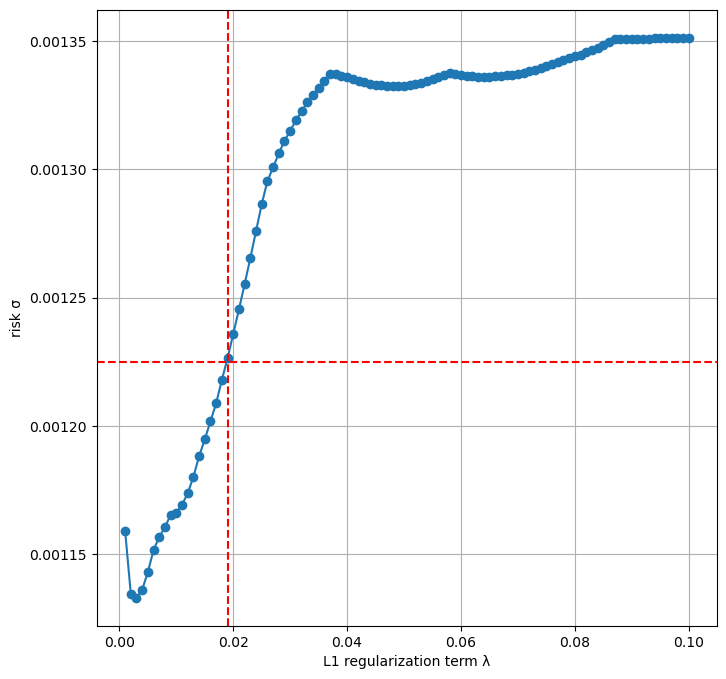

In [60]:
risk_constraint = 0.035
fig,ax = plt.subplots(figsize=(8,8))

ax.plot(alpha_list,lambda_pool,marker='o')
ax.axhline(risk_constraint**2,color='r',ls='--')
ax.axvline(alpha_list[18],color='r',ls='--')
ax.set_xlabel('L1 regularization term λ')
ax.set_ylabel('risk σ')
ax.grid()
plt.show()

0.02

In [47]:
np.hstack([weight_all,weight_all,weight_all]).shape

(22, 3)

In [54]:
# train part
        lasso = Lasso(alpha=a,fit_intercept=False)
        lasso.fit(U[train],response_df[train])
        weight_u = lasso.coef_.reshape(-1,1)
        
        # weight total
        mu_f, SIGMA_f = mu_sigma(f.iloc[train])
        weight_f = (np.linalg.inv(SIGMA_f) @ mu_f)/np.sqrt(sharpe_f)
        weight_all = risk_constraint * np.vstack((np.sqrt(sharpe_f/sharpe_all_adj)*weight_f-np.sqrt(sharpe_u_adj/sharpe_all_adj)*(beta@weight_u),
                                                 np.sqrt(sharpe_u_adj/sharpe_all_adj)*weight_u))

array([-0.,  0., -0., -0., -0., -0.,  0., -0.,  0., -0., -0.,  0.,  0.,
       -0.,  0., -0.,  0.,  0., -0.,  0.])

In [161]:
sharpe_all_adj

0.29395484594424953

In [174]:
r = np.array(f)
mu = r.mean(axis=0).reshape(-1,1)
SIGMA = np.dot((r - mu.T).T,(r - mu.T))/(T-1)

In [176]:
mu[0]/np.sqrt(SIGMA[0][0])

array([0.4052286])

In [127]:
class MAXSER:
    def __init__(self,stock,factor,T):
        self.stock = stock
        self.factor = factor
        self.T = T
    def OLS(B,A):
        '''
        计算Ax=B的OLS结果
        '''
        beta = np.linalg.lstsq(np.dot(A.T,A),np.dot(A.T,B),rcond=None)[0]
        U = np.array(B) - np.array(A)@beta
        return beta,U
    
    def sharpe(r,adjust=False):
        '''
        获得一个rolling windows的beta值
        '''
        r = np.array(r) # 调整数据格式
        T = r.shape[0]
        N = r.shape[1]
    
        mu = r.mean(axis=0).reshape(-1,1)
        SIGMA = np.dot((r - mu.T).T,(r - mu.T))/(T-1)
        
        # sharpe比
        sharpe_s_all = mu.T @ np.linalg.inv(SIGMA) @ mu # 没调整的sharpe比
        if adjust:
            # 调整sharpe
            B = lambda x,a,b:quad(lambda y:(y**(a-1))*((1-y)**(b-1)),0,x)[0]
            sharpe_all_adj1 = ((T-N-2)*sharpe_s_all-N)/T
            sharpe_all_adj2 = (2*np.power(sharpe_s_all,N/2)*np.power(1+sharpe_s_all,(T-2)/(-2)))
            sharpe_all_adj3 = (T*B((sharpe_s_all/(1+sharpe_s_all)),N/2,(T-N)/2))
            sharpe_all_adj = sharpe_all_adj1+sharpe_all_adj2/sharpe_all_adj3
                                
            return sharpe_all_adj[0][0]
        else:
            return sharpe_s_all[0][0]
    
    def subpool(r,f,subsize,n):
        '''
        筛选夏普比最大的子股票池
        '''
        sharpe_pool = [] # 储存所有sharpe比
        col_pool = [] # 储存所有columns

        # 随机挑选子股票池并循环该过程
        for _ in range(n):
            substock = np.random.choice(r.columns,subsize,replace=False)
            col_pool.append(substock)
            
            total = np.array(pd.concat([f,r[substock]],axis=1)) # 合成total，用以计算总体的sharpe
            subsharpe = sharpe_adj(total)
            sharpe_pool.append(subsharpe)

        # 筛选sharpe比在95%处的投资组合
        sharpe_pool = np.array(sharpe_pool)
        selected_index = np.where(sharpe_pool >= np.quantile(sharpe_pool,0.95))[0]
        selected_index = selected_index[np.argmin(sharpe_pool[selected_index])]
        selected_col = col_pool[selected_index]
        
        return selected_col
    def mu_sigma(r):
        '''
        得到一组收益率序列的平均值与协方差矩阵
        '''
        r = np.array(r) # 调整数据格式
        T = r.shape[0]
        mu = r.mean(axis=0).reshape(-1,1)
        SIGMA = np.dot((r - mu.T).T,(r - mu.T))/(T-1)
        return mu,SIGMA
        
        

['qsba6', 'pps9', 'rtv12', 'date', 'date', 'date']

In [86]:
#def sharpe():
stock1 = stock.iloc[:T,:]
factor1 = factor.iloc[:T,:]

subsize = 20 # 筛选

# 计入函数的部分
r = stock1.dropna(axis=1).drop('date',axis=1).iloc[:,:subsize]
f = factor1.dropna(axis=1).drop('date',axis=1)

N = r.shape[1]
K = f.shape[1]

# 利用矩阵运算
beta = np.linalg.lstsq(np.dot(f.T,f),np.dot(f.T,r),rcond=None)[0]

total = np.array(pd.concat([f,r],axis=1))
mu = total.mean(axis=0).reshape(-1,1)
SIGMA = np.dot((total - mu.T).T,(total - mu.T))

sharpe_s_all = mu.T @ np.linalg.inv(SIGMA) @ mu

# 调整sharpe
B = lambda x,a,b:quad(lambda y:(y**(a-1))*((1-y)**(b-1)),0,x)[0]
sharpe_all_adj = ((T-N-K-2)*sharpe_s_all-N-K)/T \
                    + (2*np.power(sharpe_s_all,(N+K)/2)*np.power(1+sharpe_s_all,(T-2)/(-2)))/ \
                    (T*B((sharpe_s_all/(1+sharpe_s_all)),(N+K)/2,(T-N-K)/2))